In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import pickle
from sklearn.model_selection import KFold
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras import losses

Using TensorFlow backend.


## Import, Curate

In [2]:
df = pd.read_csv(open('all.csv','r'), index_col=0)
list(df)

['init_enr',
 'bu',
 'h-3',
 'he-4',
 'u-234',
 'u-235',
 'u-236',
 'u-237',
 'u-238',
 'u-239',
 'np-237',
 'np-238',
 'np-239',
 'pu-238',
 'pu-239',
 'pu-240',
 'pu-241',
 'pu-242',
 'pu-243',
 'pu-244',
 'am-241',
 'am-242m',
 'am-242',
 'am-243',
 'am-244m',
 'am-244',
 'cm-242',
 'cm-243',
 'cm-244',
 'cm-245',
 'cm-246',
 'cm-247',
 'cm-248',
 'ge-73',
 'ge-74',
 'as-75',
 'ge-76',
 'se-77',
 'se-78',
 'se-79',
 'se-80',
 'br-81',
 'se-82',
 'kr-82',
 'kr-83',
 'kr-84',
 'kr-85',
 'kr-85m',
 'rb-85',
 'kr-86',
 'rb-86',
 'sr-86',
 'kr-87',
 'rb-87',
 'kr-88',
 'sr-88',
 'sr-89',
 'y-89',
 'sr-90',
 'y-90',
 'zr-90',
 'sr-91',
 'y-91',
 'y-91m',
 'zr-91',
 'sr-92',
 'y-92',
 'zr-92',
 'y-93',
 'zr-93',
 'y-94',
 'zr-94',
 'mo-94',
 'zr-95',
 'nb-95',
 'nb-95m',
 'mo-95',
 'zr-96',
 'mo-96',
 'zr-97',
 'nb-97',
 'mo-97',
 'mo-98',
 'mo-99',
 'tc-99',
 'tc-99m',
 'ru-99',
 'mo-100',
 'ru-100',
 'mo-101',
 'tc-101',
 'ru-101',
 'mo-102',
 'ru-102',
 'ru-103',
 'rh-103',
 'rh-103m',


In [3]:
# nan to zero
df = df.fillna(0)

In [4]:
rank_dict = {}
for column in list(df)[2:]:
    rank_dict[column] = sum(df[column])
# sort rank_dict for isotope with biggest 100 values
first_100 = sorted(rank_dict, key=rank_dict.get, reverse=True)[:100]

In [5]:
df = df[['bu', 'init_enr'] + first_100]

## Visualize,

In [6]:
import matplotlib.pyplot as plt

Number of assemblies in this dataframe: 40000


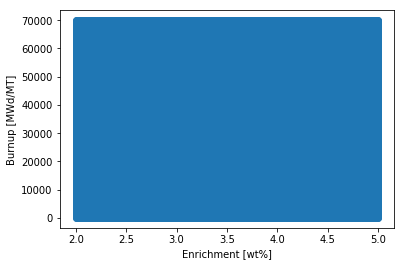

In [7]:
print('Number of assemblies in this dataframe: %i' %np.shape(df)[0])
plt.scatter(df['init_enr'], df['bu'])
plt.xlabel('Enrichment [wt%]')
plt.ylabel('Burnup [MWd/MT]')
plt.show()

## Scale (normalize), Prepare to train

In [8]:
x = df[['init_enr', 'bu']].values
y = df.iloc[:,2:].values

In [9]:
xscaler = MinMaxScaler().fit(x)
yscaler = MinMaxScaler().fit(y)
xscale = xscaler.transform(x)
yscale = yscaler.transform(y)
iso_list = list(df.iloc[:,2:])

In [10]:
def run_model(hidden_layers_=3,
              node_per_hidden_layer_=4,
              dropout_rate_=0,
              output_activation_='linear',
              epochs_=500,
              batch_size_=50,
              hidden_layer_activation_='relu',
              return_model=False,
              loss_function_='mse'
              ):
    cvscores = []
    kfold = KFold(n_splits=3)
    param_dict = {'hidden_layers':hidden_layers_,
                  'node_per_hidden_layer': node_per_hidden_layer_,
                  'dropout_rate': dropout_rate_,
                  'output_activation': output_activation_,
                  'epochs': epochs_,
                  'batch_size': batch_size_}
    print('\n Running:\n', param_dict)
    for train, test in kfold.split(xscale):
        model = Sequential()
        model.add(Dense(len(xscale[0]), input_dim=2, kernel_initializer='normal', activation='relu'))
        for i in range(hidden_layers_):
            model.add(Dense(node_per_hidden_layer_,
                            activation=hidden_layer_activation_))
            if dropout_rate_ != 0:
                model.add(Dropout(dropout_rate_))
        model.add(Dense(len(yscale[0]), activation=output_activation_))
        model.compile(loss=loss_function_, optimizer='adam',
                      metrics=['mse', 'mae'])
        model.fit(xscale[train], yscale[train],
                  epochs=epochs_, batch_size=batch_size_,
                  verbose=0)
        scores = model.evaluate(xscale[test], yscale[test])
        print('%s: %.2f%%' %(model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
    print('%.2f%% (+/- %.2f%%)' %(np.mean(cvscores), np.std(cvscores)))
    if return_model:
        # so the model that eventually gets stored / used
        # is only trained on 2/3 of data. 
        model_dict = {'model': model,
                      'xscaler': xscaler,
                      'yscaler': yscaler,
                      'iso_list': list(all_dat.iloc[:, 5:])
                      }
        f = open('ann_model.pkl', 'wb')
        pickle.dump(model_dict, f)
        f.close()
        return model_dict
    return param_dict, np.mean(cvscores)

In [11]:
def hyperparameter_search(hidden_layers_list=range(1,5),
                          node_per_hidden_list=[4, 8, 16, 32],
                          dropout_rate_list=[0],
                          output_activation_list=['linear', 'sigmoid'],
                          epochs_list=[500],
                          batch_size_list=[50],
                          hidden_layer_activation_list=['relu'],
                          loss_function='mse'):
    score_model_dict = {}
    for _hidden_layers in hidden_layers_list:
        for _node_per_hidden_layer in node_per_hidden_list:
            for _dropout_rate in dropout_rate_list:
                for _output_activation in output_activation_list:
                    for _epochs in epochs_list:
                        for _batch_size in batch_size_list:
                            for _hidden_layer_activation in hidden_layer_activation_list:
                                param_dict, score = run_model(hidden_layers_=_hidden_layers,
                                                              node_per_hidden_layer_= _node_per_hidden_layer,
                                                              dropout_rate_=_dropout_rate,
                                                              output_activation_=_output_activation,
                                                              epochs_=_epochs,
                                                              batch_size_=_batch_size,
                                                              hidden_layer_activation_=_hidden_layer_activation,
                                                              loss_function_=loss_function)
                                score_model_dict[score] = param_dict
                                f = open('ann.pkl', 'wb')
                                pickle.dump(score_model_dict, f)
                                f.close()
    min_key = min(score_model_dict.keys())
    best_param_dict = score_model_dict[min_key]
    print('Best performing hyperparameter set:\n', best_param_dict)
    return best_param_dict

In [12]:
best_param_dict = hyperparameter_search()


 Running:
 {'hidden_layers': 1, 'node_per_hidden_layer': 4, 'dropout_rate': 0, 'output_activation': 'linear', 'epochs': 500, 'batch_size': 50}
13334/13334 [==============================] - 0s 15us/step
mean_squared_error: 0.26%
13333/13333 [==============================] - 0s 16us/step
mean_squared_error: 0.27%
13333/13333 [==============================] - 0s 16us/step
mean_squared_error: 7.08%
2.54% (+/- 3.21%)

 Running:
 {'hidden_layers': 1, 'node_per_hidden_layer': 4, 'dropout_rate': 0, 'output_activation': 'sigmoid', 'epochs': 500, 'batch_size': 50}
13334/13334 [==============================] - 0s 18us/step
mean_squared_error: 7.17%
13333/13333 [==============================] - 0s 18us/step
mean_squared_error: 0.38%
13333/13333 [==============================] - 0s 19us/step
mean_squared_error: 0.37%
2.64% (+/- 3.20%)

 Running:
 {'hidden_layers': 1, 'node_per_hidden_layer': 8, 'dropout_rate': 0, 'output_activation': 'linear', 'epochs': 500, 'batch_size': 50}
13334/13334 [==

13334/13334 [==============================] - 1s 75us/step
mean_squared_error: 0.03%
13333/13333 [==============================] - 1s 70us/step
mean_squared_error: 0.07%
13333/13333 [==============================] - 1s 77us/step
mean_squared_error: 0.23%
0.11% (+/- 0.09%)

 Running:
 {'hidden_layers': 3, 'node_per_hidden_layer': 16, 'dropout_rate': 0, 'output_activation': 'linear', 'epochs': 500, 'batch_size': 50}
13334/13334 [==============================] - 1s 75us/step
mean_squared_error: 0.22%
13333/13333 [==============================] - 1s 77us/step
mean_squared_error: 0.00%
13333/13333 [==============================] - 1s 75us/step
mean_squared_error: 0.00%
0.08% (+/- 0.10%)

 Running:
 {'hidden_layers': 3, 'node_per_hidden_layer': 16, 'dropout_rate': 0, 'output_activation': 'sigmoid', 'epochs': 500, 'batch_size': 50}
13334/13334 [==============================] - 1s 73us/step
mean_squared_error: 0.01%
13333/13333 [==============================] - 1s 77us/step
mean_square

In [13]:
best_param_dict

{'hidden_layers': 1,
 'node_per_hidden_layer': 8,
 'dropout_rate': 0,
 'output_activation': 'linear',
 'epochs': 500,
 'batch_size': 50}

In [23]:
# getting that model
thr = int(len(xscale) / 3 *2)
print(two_thirds_line)
model = Sequential()
model.add(Dense(2, input_dim=2, kernel_initializer='normal', activation='relu'))
for i in range(best_param_dict['hidden_layers']):
    model.add(Dense(best_param_dict['node_per_hidden_layer'], activation='relu'))
model.add(Dense(len(yscale[0]), activation=best_param_dict['output_activation']))
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
model.fit(xscale[:thr], yscale[:thr], epochs=500, batch_size=50, verbose=0)

26666


In [24]:
model.evaluate(xscale[thr:], yscale[thr:])

13334/13334 [==============================] - 2s 135us/step


[0.0024122181172316856, 0.0024122181172316856, 0.031248852327014527]

In [26]:
pickle_dict = {'model': model,
               'iso_list': iso_list,
               'xscaler' : xscaler,
               'yscaler': yscaler}
pickle.dump(pickle_dict, open('ann_model.pkl', 'wb'))